In [1]:
!pip install nx-arangodb

In [2]:
!nvidia-smi
!nvcc --version

Sat Mar  8 17:09:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 571.96                 Driver Version: 571.96         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0             17W /  140W |       0MiB /   8188MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com 

In [3]:
!pip install --upgrade langchain langchain-community langchain-openai langgraph

  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.41
    Uninstalling langchain-core-0.3.41:
      Successfully uninstalled langchain-core-0.3.41
  Attempting uninstall: langchain-openai
    Found existing installation: langchain-openai 0.3.7
    Uninstalling langchain-openai-0.3.7:
      Successfully uninstalled langchain-openai-0.3.7


In [2]:
import networkx as nx
import nx_arangodb as nxadb
from arango import ArangoClient
import numpy as np
import networkx as nx
from random import randint
import re
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tooly

[22:30:46 +0530] [INFO]: NetworkX-cuGraph is unavailable: No module named 'cupy'.


ImportError: cannot import name 'tooly' from 'langchain_core.tools' (c:\Users\Arvapalli Manikanta\anaconda3\envs\rapids_env\lib\site-packages\langchain_core\tools\__init__.py)

In [3]:
import langchain_core.tools
print(dir(langchain_core.tools))

['ArgsSchema', 'BaseTool', 'BaseToolkit', 'FILTERED_ARGS', 'InjectedToolArg', 'InjectedToolCallId', 'RetrieverInput', 'SchemaAnnotationError', 'StructuredTool', 'Tool', 'ToolException', 'ToolsRenderer', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_get_runnable_config_param', 'annotations', 'base', 'convert', 'convert_runnable_to_tool', 'create_retriever_tool', 'create_schema_from_function', 'render', 'render_text_description', 'render_text_description_and_args', 'retriever', 'simple', 'structured', 'tool']


In [ ]:
db = ArangoClient(hosts="Arango URL").db(username="root", password="DB password", verify=True)
print(db)

<StandardDatabase _system>


In [7]:
import pandas as pd

In [8]:
NXT = pd.read_csv(
    "NTX.txt",
    names=["FromNodeId", "ToNodeId"],
)
NXT

,FromNodeId,ToNodeId
0,4593618\t3465673,NaN
1,4593619\t2348073,NaN
2,4593619\t2371525,NaN
3,4593619\t3221652,NaN
4,4593619\t4384526,NaN
...,...,...
4129733,5154093\t3393578,NaN
4129734,5154093\t3528312,NaN
4129735,5154093\t3710645,NaN
4129736,5154093\t4011770,NaN


In [9]:
G = nx.from_pandas_edgelist(NXT, "FromNodeId", "ToNodeId")
print(G)

Graph with 8259476 nodes and 4129738 edges


In [59]:
import torch

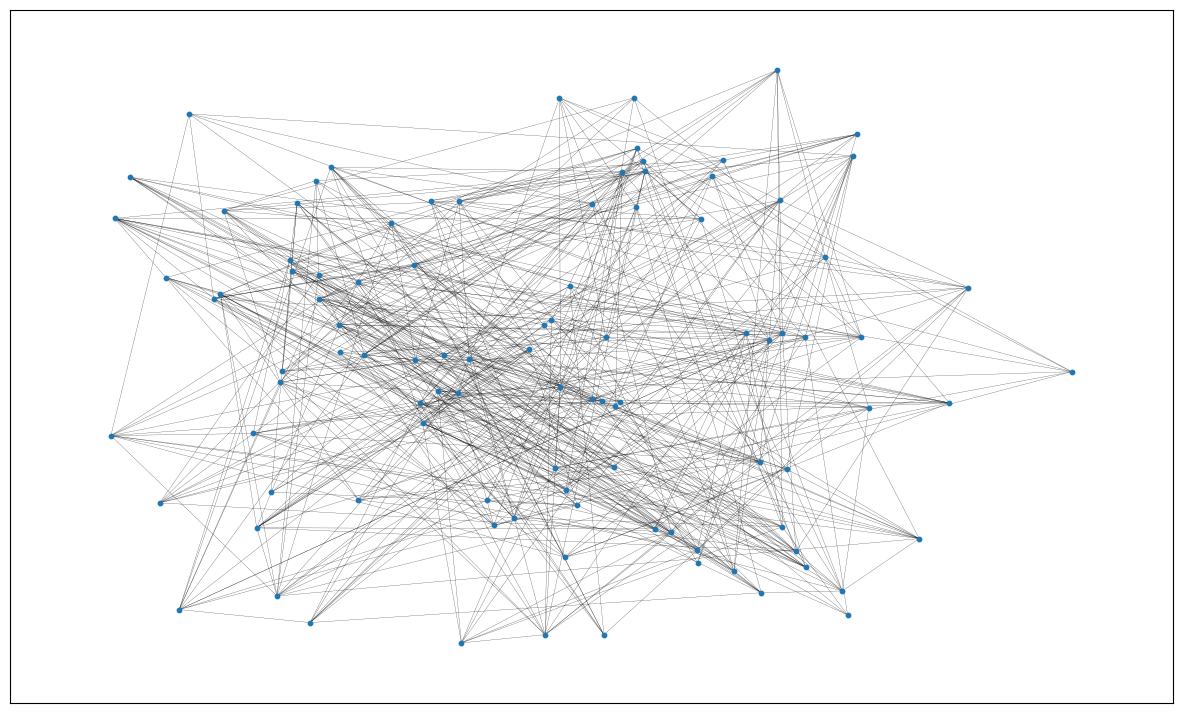

In [60]:
 # Move computations to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate a random graph
G = nx.erdos_renyi_graph(100, 0.1)  # Change as needed

# Convert graph nodes to tensor
nodes = torch.tensor(list(G.nodes), dtype=torch.float32).to(device)

# Generate random initial positions
pos_tensor = torch.rand((len(nodes), 2), device=device)

# Simulate attraction and repulsion forces for layout
for _ in range(100):  # Increase iterations for better layout
    displacement = torch.randn_like(pos_tensor) * 0.01  # Small random movements
    pos_tensor += displacement

# Move positions back to CPU for plotting
pos = {n.item(): (p[0].item(), p[1].item()) for n, p in zip(nodes, pos_tensor.cpu())}

# Plot the graph
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(G, pos=pos, node_size=10, with_labels=False, width=0.15)
plt.show()

In [64]:
# 1. Load the NetworkX Graph into ArangoDB
# Reference: https://github.com/arangodb/nx-arangodb?tab=readme-ov-file#can-i-create-an-arangodb-graph-from-an-existing-networkx-graph
G_adb = nxadb.Graph(
    name="NTX",
    db=db,
    incoming_graph_data=G,
    write_batch_size=50000,
    overwrite_graph=True  # This will clear the existing graph and load the new one
)

[19:36:29 +0530] [INFO]: Overwriting graph 'NTX'
INFO:nx_arangodb:Overwriting graph 'NTX'
[19:36:30 +0530] [INFO]: Graph 'NTX' exists.
INFO:nx_arangodb:Graph 'NTX' exists.
[19:36:31 +0530] [INFO]: Default node type set to 'NTX_node'
INFO:nx_arangodb:Default node type set to 'NTX_node'
[2025/03/08 19:36:32 +0530] [20576] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'
INFO:adbnx_adapter:Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/03/08 21:21:43 +0530] [20576] [INFO] - adbnx_adapter: Created ArangoDB 'NTX' Graph
INFO:adbnx_adapter:Created ArangoDB 'NTX' Graph


In [10]:
G_adb = nxadb.Graph(
    name="NTX",
    db=db
)

[22:32:40 +0530] [INFO]: Graph 'NTX' exists.
[22:32:40 +0530] [INFO]: Default node type set to 'NTX_node'


In [11]:
print(G_adb.number_of_nodes())  # Should match the expected count


8259476


In [12]:
print(G_adb.number_of_edges())  # Should match the expected count

4129738


In [13]:
# 2. Re-connect to the same Graph

G_adb = nxadb.Graph(name="NTX", db=db)

print(G_adb)

[22:32:44 +0530] [INFO]: Graph 'NTX' exists.
[22:32:45 +0530] [INFO]: Default node type set to 'NTX_node'


Graph named 'NTX' with 8259476 nodes and 4129738 edges


In [14]:
result = G_adb.query("""
    FOR node IN NTX_node
        SORT RAND()
        LIMIT 3
        RETURN node
""")

print(list(result))
print('-'*10)

# Sample 3 edges
result = G_adb.query("""
    FOR edge IN NTX_node_to_NTX_node
        SORT RAND()
        LIMIT 3
        RETURN edge
""")

print(list(result))
print('-'*10)

# Traverse a node's 1-hop neighborhood
result = G_adb.query("""
    FOR node, edge, path IN 1..1 ANY 'NTX_node/1' GRAPH NTX
        LIMIT 1
        RETURN path
""")

print(list(result))


[{'_key': '7172284', '_id': 'NTX_node/7172284', '_rev': '_jVWwILy--B'}, {'_key': '1696881', '_id': 'NTX_node/1696881', '_rev': '_jVWZesC--h'}, {'_key': '4549413', '_id': 'NTX_node/4549413', '_rev': '_jVWmDQ6-_q'}]
----------
[{'_key': '1048514', '_id': 'NTX_node_to_NTX_node/1048514', '_from': 'NTX_node/2097028', '_to': 'NTX_node/2097029', '_rev': '_jVXDlZ2--y'}, {'_key': '686409', '_id': 'NTX_node_to_NTX_node/686409', '_from': 'NTX_node/1372818', '_to': 'NTX_node/1372819', '_rev': '_jVW8ybe-_G'}, {'_key': '425380', '_id': 'NTX_node_to_NTX_node/425380', '_from': 'NTX_node/850760', '_to': 'NTX_node/850761', '_rev': '_jVW5Dq2--L'}]
----------
[{'vertices': [{'_key': '1', '_id': 'NTX_node/1', '_rev': '_jVWSSUy--_'}, {'_key': '0', '_id': 'NTX_node/0', '_rev': '_jVWSSUy---'}], 'edges': [{'_key': '0', '_id': 'NTX_node_to_NTX_node/0', '_from': 'NTX_node/0', '_to': 'NTX_node/1', '_rev': '_jVW0_OS---'}], 'weights': [0, 1]}]


In [15]:

print(G_adb.nodes[1])
print(G_adb.nodes["1"])
print(G_adb.nodes["NTX_node/1"])

print('----')

print(G_adb[0][1])
print(G_adb["0"][1])
print(G_adb["NTX_node/0"][1])

{'_key': '1', '_id': 'NTX_node/1'}
{'_key': '1', '_id': 'NTX_node/1'}
{'_key': '1', '_id': 'NTX_node/1'}
----
{'_from': 'NTX_node/0', '_id': 'NTX_node_to_NTX_node/0', '_key': '0', '_to': 'NTX_node/1'}
{'_from': 'NTX_node/0', '_id': 'NTX_node_to_NTX_node/0', '_key': '0', '_to': 'NTX_node/1'}
{'_from': 'NTX_node/0', '_id': 'NTX_node_to_NTX_node/0', '_key': '0', '_to': 'NTX_node/1'}


In [16]:
arango_graph = ArangoGraph(db)

In [ ]:
import os
import openai

os.environ["OPENAI_API_KEY"] = "KEEP our api key here"

llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

llm.invoke("hello!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 9, 'total_tokens': 19, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-93030e0e-cfbb-4c85-83a6-8659310664c0-0', usage_metadata={'input_tokens': 9, 'output_tokens': 10, 'total_tokens': 19, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [18]:
from langchain.tools import tool

@tool
def favourite_fruit(query: str) -> str:
    """You are responsible for responding to being asked what your favourite fruit is.
    You must say Avocado!
    """
    return "Avocado!"


In [19]:
@tool
def text_to_aql_to_text(query: str):
    """This tool is available to invoke the
    ArangoGraphQAChain object, which enables you to
    translate a Natural Language Query into AQL, execute
    the query, and translate the result back into Natural Language.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    chain = ArangoGraphQAChain.from_llm(
    	llm=llm,
    	graph=arango_graph,
    	verbose=True,
        allow_dangerous_requests=True
    )
    
    result = chain.invoke(query)

    return str(result["result"])

In [20]:
@tool
def text_to_nx_algorithm_to_text(query):
    """This tool is available to invoke a NetworkX Algorithm on
    the ArangoDB Graph. You are responsible for accepting the
    Natural Language Query, establishing which algorithm needs to
    be executed, executing the algorithm, and translating the results back
    to Natural Language, with respect to the original query.

    If the query (e.g traversals, shortest path, etc.) can be solved using the Arango Query Language, then do not use
    this tool.
    """

    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")

    ######################
    print("1) Generating NetworkX code")

    text_to_nx = llm.invoke(f"""
    I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

    I have the following graph analysis query: {query}.

    Generate the Python Code required to answer the query using the `G_adb` object.

    Be very precise on the NetworkX algorithm you select to answer this query. Think step by step.

    Only assume that networkx is installed, and other base python dependencies.

    Always set the last variable as `FINAL_RESULT`, which represents the answer to the original query.

    Only provide python code that I can directly execute via `exec()`. Do not provide any instructions.

    Make sure that `FINAL_RESULT` stores a short & consice answer. Avoid setting this variable to a long sequence.

    Your code:
    """).content

    text_to_nx_cleaned = re.sub(r"^```python\n|```$", "", text_to_nx, flags=re.MULTILINE).strip()
    
    print('-'*10)
    print(text_to_nx_cleaned)
    print('-'*10)

    ######################

    print("\n2) Executing NetworkX code")
    global_vars = {"G_adb": G_adb, "nx": nx}
    local_vars = {}

    try:
        exec(text_to_nx_cleaned, global_vars, local_vars)
        text_to_nx_final = text_to_nx
    except Exception as e:
        print(f"EXEC ERROR: {e}")
        return f"EXEC ERROR: {e}"

        # TODO: Consider experimenting with a code corrector!
        attempt = 1
        MAX_ATTEMPTS = 3

        # while attempt <= MAX_ATTEMPTS
            # ...

    print('-'*10)
    FINAL_RESULT = local_vars["FINAL_RESULT"]
    print(f"FINAL_RESULT: {FINAL_RESULT}")
    print('-'*10)

    ######################

    print("3) Formulating final answer")

    nx_to_text = llm.invoke(f"""
        I have a NetworkX Graph called `G_adb`. It has the following schema: {arango_graph.schema}

        I have the following graph analysis query: {query}.

        I have executed the following python code to help me answer my query:

        ---
        {text_to_nx_final}
        ---

        The `FINAL_RESULT` variable is set to the following: {FINAL_RESULT}.

        Based on my original Query and FINAL_RESULT, generate a short and concise response to
        answer my query.
        
        Your response:
    """).content

    return nx_to_text

In [21]:
tools = [text_to_aql_to_text, text_to_nx_algorithm_to_text, favourite_fruit]

def query_graph(query):
    llm = ChatOpenAI(temperature=0, model_name="gpt-4o")
    app = create_react_agent(llm, tools)    
    final_state = app.invoke({"messages": [{"role": "user", "content": query}]})
    return final_state["messages"][-1].content

In [22]:
query_graph("Find the most cited patents ")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH NTX_node, NTX_node_to_NTX_node
FOR v, e, p IN 1..1 OUTBOUND 'NTX_node/0' NTX_node_to_NTX_node
COLLECT patent = v WITH COUNT INTO citationCount
SORT citationCount DESC
RETURN { patent, citationCount }

AQL Result:
[{'patent': {'_key': '1', '_id': 'NTX_node/1', '_rev': '_jVWSSUy--_'}, 'citationCount': 1}]

> Finished chain.


"The most cited patent in the database is identified by the key '1', with a total of 1 citation."

In [23]:
query_graph("Find the most recent patents getting cited rapidly")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH NTX_node, NTX_node_to_NTX_node
FOR patent IN NTX_node
    LET citations = (
        FOR edge IN NTX_node_to_NTX_node
            FILTER edge._to == patent._id
            COLLECT WITH COUNT INTO citationCount
            RETURN citationCount
    )
    SORT citations DESC
    LIMIT 10
    RETURN {
        patent: patent,
        citationCount: citations
    }



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH NTX_node, NTX_node_to_NTX_node
FOR patent IN NTX_node
    LET citations = (
        FOR edge IN NTX_node_to_NTX_node
            FILTER edge._to == patent._id
            COLLECT WITH COUNT INTO citationCount
            RETURN citationCount
    )
    SORT citations[0] DESC
    LIMIT 10
    RETURN {
        patent: patent,
        citationCount: citations[0]
    }



'I am currently unable to access the database to retrieve the information about the most recent patents getting cited rapidly due to a timeout error. Please try again later or check the database connection.'

In [25]:
query_graph("Identify companies whose patents are cited the most ")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH NTX_node, NTX_node_to_NTX_node
FOR v, e, p IN 1..1 OUTBOUND 'NTX_node/0' NTX_node_to_NTX_node
COLLECT company = v._key WITH COUNT INTO citationCount
SORT citationCount DESC
RETURN { company, citationCount }

AQL Result:
[{'company': '1', 'citationCount': 1}]

> Finished chain.


"The company with the most cited patents in the database is identified by the key '1', with a total of 1 citation."

In [26]:
query_graph("8.	Find inventors with the highest number of patents ")



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH NTX_node, NTX_node_to_NTX_node
FOR inventor IN NTX_node
    LET patentCount = LENGTH(
        FOR v, e IN 1..1 OUTBOUND inventor NTX_node_to_NTX_node
        RETURN v
    )
    SORT patentCount DESC
    RETURN { inventor: inventor, patentCount: patentCount }



> Entering new ArangoGraphQAChain chain...
AQL Query (1):
WITH NTX_node, NTX_node_to_NTX_node
FOR inventor IN NTX_node
    LET patentCount = LENGTH(
        FOR patent IN NTX_node_to_NTX_node
            FILTER patent._from == inventor._id
            RETURN patent
    )
    SORT patentCount DESC
    LIMIT 1
    RETURN { inventor: inventor, patentCount: patentCount }



'I am currently experiencing difficulties accessing the database to retrieve the information. Please try again later or check the database connection.'

In [33]:
 

# Optimized AQL Query
query = """
WITH NTX_node, NTX_node_to_NTX_node
FOR patent IN NTX_node
    FILTER patent.date >= DATE_SUBTRACT(DATE_NOW(), 365, "day") /* Last 1 year */
    LET citationCount = LENGTH(
        FOR edge IN NTX_node_to_NTX_node
            FILTER edge._to == patent._id
            RETURN 1
    )
    FILTER citationCount > 0 /* Only patents with citations */
    SORT citationCount DESC
    LIMIT 10
    RETURN {
        patent: patent,
        citationCount: citationCount
    }
"""

# Execute query
cursor = db.aql.execute(query)
results = list(cursor)

# Print results
for res in results:
    print(f"Patent ID: {res['patent']['_id']}, Citations: {res['citationCount']}")


In [38]:
# Get all edges (citations)
edges = list(G_adb.edges())

# Count incoming citations for each patent (_to nodes)
citation_counts = {}
for from_patent, to_patent in edges:
    citation_counts[to_patent] = citation_counts.get(to_patent, 0) + 1

# Sort patents by citation count (descending)
top_cited = sorted(citation_counts.items(), key=lambda x: x[1], reverse=True)[:10]

# Retrieve detailed information for top cited patents
print("\n📌 **Top 10 Most Cited Patents**")
for patent_id, citations in top_cited:
    node_data = G_adb.nodes.get(patent_id, {})  # Get node attributes
    print(f"Patent ID: {patent_id}, Citations: {citations}, Title: {node_data.get('title', 'N/A')}, Assignee: {node_data.get('assignee', 'N/A')}")


PhenolError: Could not load edges: Some(Other("Request error: error sending request for url (https://14c3433deb43.arangodb.cloud:8529/_db/_system/_api/dump/start): error trying to connect: dns error: No such host is known. (os error 11001)"))